In [3]:
import os 
import glob
import numpy as np
from scipy.signal import butter, lfilter
import math
import re

In [40]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def compute_DE(signal):
    variance = np.var(signal, ddof=1)
    return (math.log(2 * math.pi * math.e * variance) / 2 ) 

In [41]:
import glob

import os 

import mne 
# -------------------------------------------------------------------
# 1) Gather file paths
# -------------------------------------------------------------------
file_paths = glob.glob('./dataset/sub-*/eeg/*.set')

def get_subject_id(filepath):
    for part in filepath.split(os.sep):
        if 'sub-' in part:
            return int(part.replace('sub-', '').strip())
    return None

# Separate into groups
alz_file_paths = []
ctrl_file_paths = []
ftd_file_paths = []

for fpath in file_paths:
    subj_id = get_subject_id(fpath)
    if subj_id is None:
        continue
    if 1 <= subj_id <= 36:
        alz_file_paths.append(fpath)
    elif 37 <= subj_id <= 65:
        ctrl_file_paths.append(fpath)
    elif subj_id >= 66:
        ftd_file_paths.append(fpath)

# Frequency bands
freq_bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma": (30, 45)
}

In [42]:
import os
import re
import numpy as np
import mne
from scipy.signal import butter, filtfilt

# Define frequency bands
freq_bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma": (30, 45)
}

def get_subject_id(filepath):
    """
    Parse the subject ID from a file path like:
    ./dataset/derivatives/sub-01/eeg/... 
    This function expects a pattern 'sub-###' in the path.
    """
    for part in filepath.split(os.sep):
        if 'sub-' in part:
            # e.g. 'sub-01' -> '01' -> int(1)
            return int(part.replace('sub-', '').strip())
    return None


def compute_DE_subjects_single_window(files_paths, output_dir, label, subject_pattern):
    """
    Computes DE features for each epoch as a single window (60 seconds).

    Parameters:
    - files_paths: List of file paths to process.
    - output_dir: Directory to save the output .npz files.
    - label: Label associated with the data (ensure it's defined or passed appropriately).
    - subject_pattern: Compiled regex pattern to extract subject number.
    """
    if label == 'ctrl':
        label_num = 0
    elif label == 'alz':
        label_num = 1
    elif label == 'ftd':
        label_num = 1

    for file_path in files_paths:
        print(f"Processing {file_path}")
        
        DE_values = []
        
        # Load raw EEG data
        raw = mne.io.read_raw_eeglab(file_path, preload=True)
        fs = int(raw.info['sfreq'])

        # Create fixed-length epochs of 60 seconds
        epochs = mne.make_fixed_length_epochs(raw, duration=60, preload=True)
        data = epochs.get_data()  # Shape: [n_epochs, n_channels, n_samples]
        data = data * 1e6  # Convert to microvolts if necessary

        num_epochs, num_channels, signal_length = data.shape
        
        window_size = 60 * fs  # 60 seconds
        num_windows = 1  # Single window per epoch

        for epoch_idx in range(num_epochs):
            start = 0
            end = window_size
            temp_signal = data[epoch_idx, :, start:end]  # Shape: [channels, window_size]
            
            window_DE = []
            
            for ch in range(num_channels):
                channel_signal = temp_signal[ch]
                
                # Apply bandpass filters for each frequency band
                delta = butter_bandpass_filter(channel_signal, freq_bands['delta'][0], freq_bands['delta'][1], fs)
                theta = butter_bandpass_filter(channel_signal, freq_bands['theta'][0], freq_bands['theta'][1], fs)
                alpha = butter_bandpass_filter(channel_signal, freq_bands['alpha'][0], freq_bands['alpha'][1], fs)
                beta = butter_bandpass_filter(channel_signal, freq_bands['beta'][0], freq_bands['beta'][1], fs)
                gamma = butter_bandpass_filter(channel_signal, freq_bands['gamma'][0], freq_bands['gamma'][1], fs)
                
                # Compute Differential Entropy for each band
                DE_delta = compute_DE(delta)
                DE_theta = compute_DE(theta)
                DE_alpha = compute_DE(alpha)
                DE_beta = compute_DE(beta)
                DE_gamma = compute_DE(gamma)
                
                channel_DE = [DE_delta, DE_theta, DE_alpha, DE_beta, DE_gamma]
                window_DE.append(channel_DE)
            
            DE_values.append(window_DE)
        
        DE_values = np.array(DE_values)  # Shape: [n_epochs, channels, bands]
        print(f"DE_values shape: {DE_values.shape}")
        
        # Expand dimensions if necessary
        # DE_values = DE_values[..., np.newaxis]  # Example: [n_epochs, channels, bands, 1]
        
        print(f"DE_values shape: {DE_values}")
        


        # Extract subject number from file name using regex
        subject_num = get_subject_id(file_path)
        
        output_file_name = f"sub-{subject_num}_DE_{label}.npz"
        output_file_path = os.path.join(output_dir, output_file_name)
        
        # Save DE features and label
        np.savez_compressed(output_file_path, DE_features=DE_values, label=label_num)
        
        print(f"Saved DE features to {output_file_path}\n")


In [ ]:
import re

# Define the output directory and ensure it exists
output_dir = './DE_features_single_window/'
os.makedirs(output_dir, exist_ok=True)

# Define the label (modify as per your data)
label = 'ctrl'  # Example label

# Compile the regex pattern to extract subject number (modify according to your filename format)
subject_pattern = re.compile(r'subject(\d+)_')  # Example pattern

# Call the function
compute_DE_subjects_single_window(ctrl_file_paths, output_dir, label, subject_pattern)
label = 'alz'
compute_DE_subjects_single_window(alz_file_paths, output_dir, label, subject_pattern)
label = 'ftd'
compute_DE_subjects_single_window(ftd_file_paths, output_dir, label, subject_pattern) 





#PSD

In [2]:
import glob

import os 

import mne 
# -------------------------------------------------------------------
# 1) Gather file paths
# -------------------------------------------------------------------
file_paths = glob.glob('./dataset/sub-*/eeg/*.set')

def get_subject_id(filepath):
    for part in filepath.split(os.sep):
        if 'sub-' in part:
            return int(part.replace('sub-', '').strip())
    return None

# Separate into groups
alz_file_paths = []
ctrl_file_paths = []
ftd_file_paths = []

for fpath in file_paths:
    subj_id = get_subject_id(fpath)
    if subj_id is None:
        continue
    if 1 <= subj_id <= 36:
        alz_file_paths.append(fpath)
    elif 37 <= subj_id <= 65:
        ctrl_file_paths.append(fpath)
    elif subj_id >= 66:
        ftd_file_paths.append(fpath)

# Frequency bands
freq_bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma": (30, 45)
}


Computing PSD for delta band (0.5-4 Hz)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)



Computing PSD for theta band (4-8 Hz)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)



Computing PSD for alpha band (8-12 Hz)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)



Computing PSD for beta band (12-30 Hz)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)



Computing PSD for gamma band (30-45 Hz)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
/tmp/ipykernel_3327519/830725448.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)


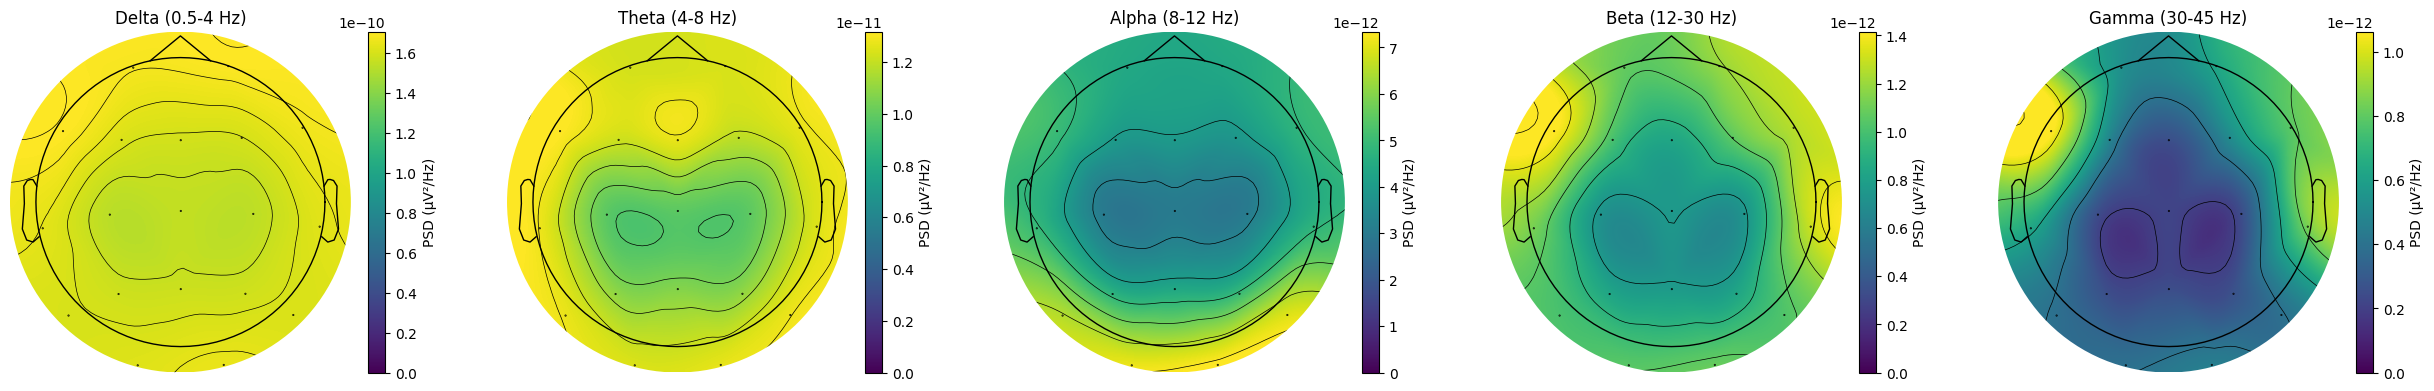

In [4]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Define your frequency bands
freq_bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma": (30, 45)
}

# 1. Create a single figure with subplots: 1 row and 5 columns
band_names = list(freq_bands.keys())
n_bands = len(band_names)
fig, axes = plt.subplots(1, n_bands, figsize=(5 * n_bands, 4))

# In case axes isn't a list (for some reason with 1 column), force it to be iterable
if n_bands == 1:
    axes = [axes]

# 2. Loop over each frequency band with an index
for i, (band_name, (fmin, fmax)) in enumerate(freq_bands.items()):
    print(f"\nComputing PSD for {band_name} band ({fmin}-{fmax} Hz)")

    # Collect PSD data from all subjects in this band
    all_psd_data = []
    for file_path in alz_file_paths:
        # 1) Load the EEG data
        raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=0)
        raw.pick_types(eeg=True)  # pick EEG channels only

        # Optionally, interpolate bad channels
        # raw.interpolate_bads(reset_bads=True)

        # Optionally, set a standard montage if channel locs are missing
        # montage = mne.channels.make_standard_montage('standard_1020')
        # raw.set_montage(montage)

        # 2) Compute PSD in the specified band
        psd_obj = raw.compute_psd(fmin=fmin, fmax=fmax, verbose=0)
        psd_data = psd_obj.get_data()  # shape = (n_channels, n_freqs)

        # 3) Average across frequencies to get a single value per channel
        psd_data_mean = psd_data.mean(axis=1)  # shape = (n_channels,)

        # 4) Collect result
        all_psd_data.append(psd_data_mean)

    # Convert list to array: shape => (n_subjects, n_channels)
    all_psd_data = np.array(all_psd_data)

    # Average across subjects: shape => (n_channels,)
    psd_avg_across_subjects = all_psd_data.mean(axis=0)

    # 3. Plot on the appropriate axis (axes[i])
    im, _ = mne.viz.plot_topomap(
        psd_avg_across_subjects,
        raw.info,
        cmap="viridis",
        axes=axes[i],
        show=False  # Important: don't show immediately
    )
    axes[i].set_title(f"{band_name.capitalize()} ({fmin}-{fmax} Hz)")

    # Add colorbar
    # Use fig.colorbar to place a colorbar for each subplot
    # or you can skip it until after the loop and do a single colorbar
    cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('PSD (µV²/Hz)', rotation=90)

# 4. Adjust layout and show everything once
plt.tight_layout()
plt.show()
